In [ ]:
# import numericals
import numpy as np
from numpy import array
from numpy import hstack
import tensorflow as tf
from numpy.random import seed
from tensorflow import random
import statsmodels.api as sm
import pandas as pd
from datetime import datetime

# import dataviz
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

# import ML and DL
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV,train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import warnings
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,Bidirectional,Flatten,Input,BatchNormalization,Reshape,GaussianNoise,Dropout,Concatenate,GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D,AveragePooling1D
from keras.wrappers.scikit_learn import KerasRegressor
import random
warnings.filterwarnings("ignore")

# import google
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
#_______________________________________________________________________________
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#_______________________________________________________________________________


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [ ]:
def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
#_______________________________________________________________________________
import tensorflow as tf
#Fórmula do cálcudo do SMAPE, utilizando TensorFlow
def smape(y_true, y_pred):
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 200.0
    diff = tf.math.divide_no_nan(tf.abs(y_true - y_pred) , denominator)
    return tf.reduce_mean(diff)
#_______________________________________________________________________________

def smape_np(y_true, y_pred):
    denominator = (abs(y_true) + abs(y_pred)) / 200.0
    diff = (abs(y_true - y_pred) , denominator)
    return np.mean(diff)
#_______________________________________________________________________________

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
#_______________________________________________________________________________
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#_______________________________________________________________________________

def lstm_seq_create(X,y,n_steps_in,n_steps_out):
# generate LSTM sequences
  xx,yy= [],[]
  for i in range(n_steps_in,X.shape[0]):
    xx.append(X[i-n_steps_in:i])
    yy.append(y[i:i+n_steps_out])
  return np.array(xx),np.array(yy) 
#_______________________________________________________________________________

def plot_training(history):
  fig=plt.figure(figsize=(9,3))
  ax=fig.add_subplot(121)
  ax.plot(history.history['loss'], label='train',color='black',lw=3.0)
  val_loss=pd.Series(history.history['val_loss'])
  ax.plot(val_loss.ewm(span=5, adjust=False).mean(), label='val',color='red',lw=3.0)
  ax.set_xlabel('epochs')
  ax.set_ylabel('loss')
  ax.legend()  
#_______________________________________________________________________________

def plot_results(prediction,y_test):
  fig=plt.figure(figsize=(8,5))
  plt.plot(prediction, color='black',lw=3, label='truth')
  plt.plot(y_test,'r-',lw=3, label='predicted')
  plt.title('Frac Treating Pressure Actual Vs. Prediction')
  plt.xlabel('Time (seconds)')
  plt.ylabel('Surface Treating Pressure (psi)')
  plt.legend()  
#_______________________________________________________________________________

def invert(prediction,y_test,data):
  y_pred=pd.DataFrame(prediction,columns=['Predicted TR PRESS'])
  y_pred['Predicted TR PRESS']=y_pred['Predicted TR PRESS']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())
  y_test=pd.DataFrame(y_test,columns=['Actual TR PRESS'])
  y_test['Actual TR PRESS']=y_test['Actual TR PRESS']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())
  return y_pred,y_test  

# **Read and pre-process dataset**

In [ ]:
# import data
data= pd.read_excel('/content/drive/My Drive/PMI5943/PROJ8/Frac_Stage_Data.xlsx')

#data= pd.read_excel('/content/drive/MyDrive/Pós PPGEN - Bolsa Molhabilidade/Disciplinas/Ciência de Dados Reservatório/PMI5943/PROJ8/Frac_Stage_Data.xlsx')

dataset=data
# separate training data
start_time = 1
end_time = 4500
filter = (dataset['Time'] > start_time) & (dataset['Time'] <= end_time)
data_training = dataset.loc[filter].copy()
# separate testing data
start_time2 = 4500
end_time2 = 4600
filter2 = (dataset['Time'] > start_time2) & (dataset['Time'] <= end_time2)
data_testing = data.loc[filter2].copy()
# cut out last 60 secs from training
past_60_secs= data_training.tail(60)
# and append them to data_testing
df_aux=past_60_secs.append(data_testing,ignore_index=True)
# here´s the final data_testing
data_testing=df_aux
# remove Time col from training
data_training.drop(['Time'], axis=1,inplace=True)
# normalize training set
scaler=MinMaxScaler()
data_training= scaler.fit_transform(data_training)
# break into X_train and y_train
X_train=data_training[:,0:3]
y_train=data_training[:,-1]
# remove Time col from testing
data_testing.drop(['Time'], axis=1,inplace=True)
# normalize testing set
data_testing= scaler.transform(data_testing)
# break into X_test and y_test
X_test=data_testing[:,0:3]
y_test=data_testing[:,-1]
# initialize lists
history_list=[]
results_list=[]

# **Experiments**

**ALL** required tasks are performed below. It´s a long notebook, but it´s all in here.



---



**1. Model "LSTM 1 layer".** Let´s reduce the number of layers, as the baseline model contains way too many layers for such a simple problem.Here we use only 1 layer.

val loss = 0.00014329419354908168

 Time taken: 0 hours 1 minutes and 23.96 seconds.


,model,val loss
0,LSTM 1 layer,0.000143


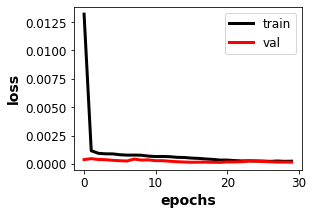

In [ ]:
# model name
model_name="LSTM 1 layer"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
dp_out=0.3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units)(inputs)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs, verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])


# # make predictions
# prediction=model.predict(Xtest)
# # invert back to PSI
# y_pred,truth=invert(prediction,ytest.reshape(len(prediction),1),data)
# # plot results
# plot_results(y_pred,truth)
# # print SMAPE
# print(f"SMAPE: {smape_np(np.array(truth), np.array(y_pred))}")

**2. Model "LSTM short LB".** As evidenced by the learning curve, and small VAL LOSS, we are going to keep the single layer model. Now, we change the look-back window from 60 to only 10 to see if VAL LOSS can be lowered. 

val loss = 0.00012415468518156558

 Time taken: 0 hours 0 minutes and 43.02 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124


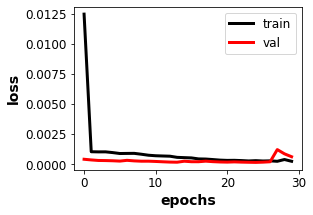

In [ ]:
# model name
model_name="LSTM short LB"
#parameter grid
n_units=256
n_steps_in=10
n_steps_out=1 
dp_out=0.3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units)(inputs)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs, verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**3. Model "LSTM long LB".** Now let´s try a LB-window=90.

val loss = 0.00012719053484033793

 Time taken: 0 hours 1 minutes and 38.36 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127


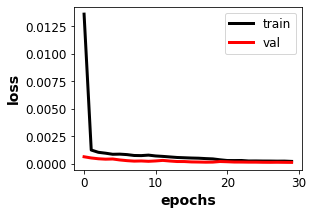

In [ ]:
# model name
model_name="LSTM long LB"
#parameter grid
n_units=256
n_steps_in=90
n_steps_out=1 
dp_out=0.3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units)(inputs)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,
                  verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**4. Model "LSTM more units".** The LSTM predicts better for LB=10 and 60. Not so well for longer LBs. The time-dependencies should not be longer than 60. We go back to LB=60 and double the number of units to see if it beats the model "LSTM 1 layer".

val loss = 0.00022140795772429556

 Time taken: 0 hours 1 minutes and 43.92 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221


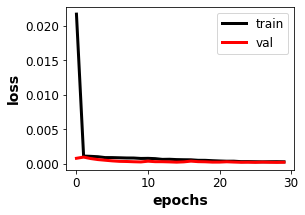

In [ ]:
# model name
model_name="LSTM 512 units"
#parameter grid
n_units=256*2
n_steps_in=60
n_steps_out=1 
dp_out=0.3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units)(inputs)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,
                  verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**5. Model "LSTM drop-out".** 512 units leads to more complexity, but roughly the same VAL LOSS. So we go back 256 units and set drop-out to 0.3.

val loss = 0.00039547967026010156

 Time taken: 0 hours 1 minutes and 7.09 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395


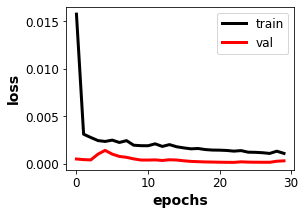

In [ ]:
# model name
model_name="LSTM drop-out"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
dp_out=0.3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units)(inputs)
x=Dropout(dp_out)(x)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#__________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs, 
                  verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**6. Model "LSTM dense".** Drop-out does nothing to improve VAL LOSS. Our model is too simple as it is, so it makes sense that a drop-out layer wouldn´t make much of a difference. Now we add a Dense layer on top of the LSTM layer. The Dense layer contains 256 neurons.

val loss = 0.00019352539675310254

 Time taken: 0 hours 1 minutes and 24.03 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194


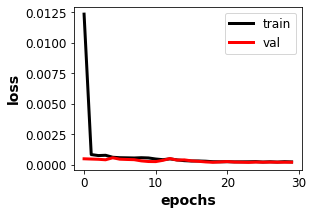

In [ ]:
# model name
model_name="LSTM+dense"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
dp_out=0.1
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_units,'relu')(x)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,
                  verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**7. Model "half-batch".** Dense layer on top does not help either. Large batches hurt generalization error. Let´s try a mini_batch=16.


val loss = 0.0002707969397306442

 Time taken: 0 hours 2 minutes and 6.29 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271


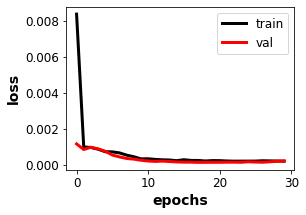

In [ ]:
# model name
model_name="LSTM+halfbatch"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,
                  batch_size=16, verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**8. Model "dense+tanh".** Let´s give Dense layers another try, but this time instead of ReLU, let´s use tanh.

val loss = 0.00014473896590061486

 Time taken: 0 hours 1 minutes and 7.78 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145


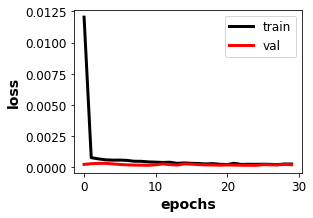

In [ ]:
# model name
model_name="LSTM+dense(tanh)"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_units,activation="tanh")(x)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**9. Model "fewer units".** Let´s now use only 64 units and drop the Dense layer.

val loss = 0.00012592844723258168

 Time taken: 0 hours 0 minutes and 52.86 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126


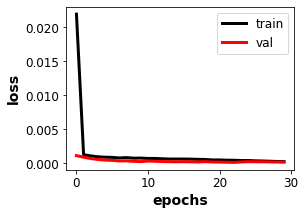

In [ ]:
# model name
model_name="LSTM 64 units"
#parameter grid
n_units=64
n_steps_in=60
n_steps_out=1 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**10. Model "RMS prop".** Let´s try RMSProp instead of Adam.

val loss = 0.0018783998675644398

 Time taken: 0 hours 1 minutes and 9.45 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


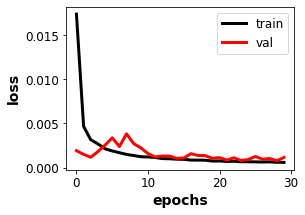

In [ ]:
# model name
model_name="RMS prop"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="rmsprop", loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**11. Model "GRU".** Let´s swap LSTM with GRU.

val loss = 0.00012364615395199507

 Time taken: 0 hours 1 minutes and 23.77 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


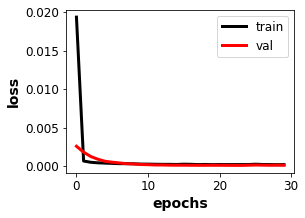

In [ ]:
# model name
model_name="GRU"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=GRU(n_units)(inputs)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**12. Model "Look-ahead=3". Predicts 3 time-steps ahead**

val loss = 0.00018464672029949725

 Time taken: 0 hours 1 minutes and 7.52 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


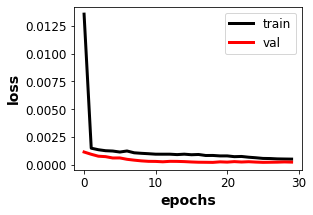

In [ ]:
# model name
model_name="Look-ahead=3"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=3 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss='mse')
#______________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, np.asarray(ytrain).astype(np.float32), epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**12. Model "Look-ahead=10". Predicts 10-time steps ahead.**

val loss = 0.0006879846332594752

 Time taken: 0 hours 1 minutes and 7.43 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


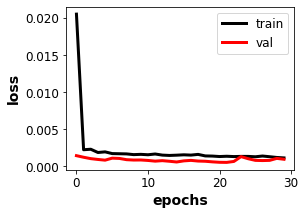

In [ ]:
# model name
model_name="Look-ahead=10"
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=10
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_steps_in,n_features))
x=LSTM(n_units)(inputs)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss='mse')
#______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, np.asarray(ytrain).astype(np.float32),
                  epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**13. Model CNN:** uses a CNN to make predictions.Predicts $p[t+1]$=$f(p[t],Q[t],C[t])$. Now we are using LB=1, and the input is no longer a sequence. The idea is to test whether a sequential input helps in the prediction of $p[t+1]$.

val loss = 0.0001784593187039718

 Time taken: 0 hours 0 minutes and 19.5 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


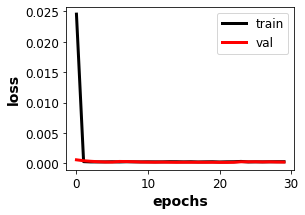

In [ ]:
# model name
model_name="CNN"
#parameter grid
n_neurons=256
n_filters=256
kernel_size=3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((n_features,1))
x=Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu')(inputs)
x=Flatten()(x)
x=Dense(n_neurons, activation='relu')(x)
x=Dense(1, activation='linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate data for CNNs
X_train_cnn=X_train[:-1,:]
y_train_cnn=y_train[1:]
X_test_cnn=X_test[:-1,:]
y_test_cnn=y_test[1:]
Xtrain = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
ytrain=y_train_cnn
Xtest = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))       
ytest=y_test_cnn
# model fit
history=model.fit(Xtrain, ytrain,
                  epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])    


**14. Model SVR**.uses a SVR to make predictions.Predicts $p[t+1]$=$f(p[t],Q[t],C[t])$. Now we are using LB=1.

In [ ]:
#model name
model_name="SVR"
# generate data for SVR
X_train_svr=X_train[:-1,:]
y_train_svr=y_train[1:]
X_test_svr=X_test[:-1,:]
y_test_svr=y_test[1:]
# define grid
grid_svr = {'kernel':['sigmoid',"rbf","linear"],
         'C':[0.1,1,10,100,1000],
         'gamma':[1,0.1,0.01,1000]}
# inner 3-fold loop for hyper-params selection
cv_inner =  KFold(n_splits=3, shuffle=True, random_state=123)
# outer 5-fold loop for generalization error 
cv_outer = KFold(5, shuffle=True,random_state= 123)
# invoke SVR
model= SVR()
# define grid search for hyper-params selection
gs= GridSearchCV(estimator=model,
                  param_grid = grid_svr,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# outer-loop for generalization error
scores_mse=cross_val_score(gs, X_train_svr,y_train_svr,cv=cv_outer,scoring='neg_mean_squared_error',n_jobs=-1)
scores_mse=-scores_mse
avg_mse=scores_mse.mean()
# print val loss
print(f"val loss = {avg_mse}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,avg_mse])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])    


val loss = 0.0021200670191993585

 Time taken: 0 hours 1 minutes and 19.39 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


**15. Model RF**.uses a RF to make predictions.Predicts $p[t+1]$=$f(p[t],Q[t],C[t])$. Now we are using LB=1.

In [ ]:
#model name
model_name="RF"
# generate data for KR
X_train_rf=X_train[:-1,:]
y_train_rf=y_train[1:]
X_test_rf=X_test[:-1,:]
y_test_rf=y_test[1:]
# define grid
grid_rf = {'max_depth':[5,15,25,30],
            'n_estimators':[10,50,100,500,1000]}
# inner 3-fold loop for hyper-params selection
cv_inner =  KFold(n_splits=3, shuffle=True, random_state=123)
# outer 5-fold loop for generalization error 
cv_outer = KFold(5, shuffle=True,random_state= 123)
# invoke RF
model= RandomForestRegressor()
# define grid search for hyper-params selection
gs= GridSearchCV(estimator=model,
                  param_grid = grid_rf,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# outer-loop for generalization error
scores_mse=cross_val_score(gs, X_train_rf,y_train_rf,cv=cv_outer,scoring='neg_mean_squared_error',n_jobs=-1)
scores_mse=-scores_mse
avg_mse=scores_mse.mean()
# print val loss
print(f"val loss = {avg_mse}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,avg_mse])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])    

val loss = 0.0002402574616096424

 Time taken: 0 hours 6 minutes and 35.76 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


**16. Model GB**.uses a GB to make predictions.Predicts $p[t+1]$=$f(p[t],Q[t],C[t])$. Now we are using LB=1.

In [ ]:
#model name
model_name="GB"
# generate data for GB
X_train_gb=X_train[:-1,:]
y_train_gb=y_train[1:]
X_test_gb=X_test[:-1,:]
y_test_gb=y_test[1:]
# define grid
grid_gb = {'learning_rate': np.linspace(0.05, 0.15,5),
            'max_depth' : range(3, 5),
            'min_samples_leaf': range(3, 5),
            'n_estimators' : [100,150,200]}
# inner 3-fold loop for hyper-params selection
cv_inner =  KFold(n_splits=3, shuffle=True, random_state=123)
# outer 5-fold loop for generalization error 
cv_outer = KFold(5, shuffle=True,random_state= 123)
# invoke GB
model=GradientBoostingRegressor()
# define grid search for hyper-params selection
gs= GridSearchCV(estimator=model,
                  param_grid = grid_gb,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# outer-loop for generalization error
scores_mse=cross_val_score(gs, X_train_gb,y_train_gb,cv=cv_outer,scoring='neg_mean_squared_error',n_jobs=-1)
scores_mse=-scores_mse
avg_mse=scores_mse.mean()
# print val loss
print(f"val loss = {avg_mse}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,avg_mse])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])    

val loss = 0.00020722734945330927

 Time taken: 0 hours 9 minutes and 7.66 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


**17. Model "LSTM+Attention".** Let´s now stack an attention layer on top of LSTM.

In [ ]:
# code from https://machinelearningmastery.com
# Add attention layer to the deep learning network
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
# model name
model_name="LSTM+attention"
#parameter grid
n_units=256
n_neurons=256
n_steps_in=60
n_steps_out=1 
dp_out=0.3
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units,return_sequences=True)(inputs)  
x=attention()(x)
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs, verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

NameError: ignored

**18. Model "Dense+CNN+LSTM".** This model blows up the feature-space using a Dense layer. Then the created features are processed by a CNN, which creates sub-sequences for the LSTM layer.

val loss = 0.00021750836458522826

 Time taken: 0 hours 2 minutes and 31.8 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


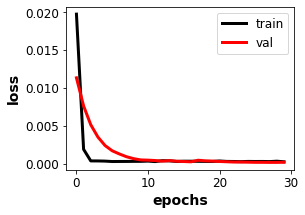

In [ ]:
# model name
model_name="Dense+CNN+LSTM"
#parameter grid
n_units=256
n_neurons=256
n_reshape=256
n_filters=256
kernel_size=9
n_steps_in=60
n_steps_out=1
pool=2 
n_epochs=30
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input(n_features)
x=Dense(n_neurons,activation='relu')(inputs)
x=Reshape((n_reshape,n_neurons//n_reshape))(x)
x=Conv1D(filters=n_filters,kernel_size=kernel_size,activation='relu')(x) 
x=MaxPooling1D(pool)(x)
x=LSTM(n_units)(x)
x=Dense(n_steps_out,activation='linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate data for CNNs
X_train_cnn=X_train[:-1,:]
y_train_cnn=y_train[1:]
X_test_cnn=X_test[:-1,:]
y_test_cnn=y_test[1:]
# model fit
history=model.fit(X_train_cnn, y_train_cnn, epochs=n_epochs, verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])

**19. Model "CNN+LSTM".** Here we use CNN for pre-processing the LB=60 into smaller chunks before feeding it to LSTM layer. 

val loss = 0.00013306991604622453

 Time taken: 0 hours 1 minutes and 23.86 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


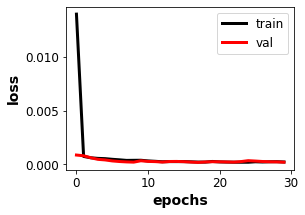

In [ ]:
# model name
model_name="CNN+LSTM"
#parameter grid
n_units=256
n_filters=256
kernel_size=3
n_epochs=30
n_steps_in=60
n_steps_out=1
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((None,n_features))
x=Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu')(inputs)
x=LSTM(n_units)(x)
x=Dense(1, activation='linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain,
                  epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])    


**20. Model "CNN-4-seq".** In this model, we are not going to use a LSTM layer. The CNN layer will process the sequential data and then subsequent features maps will be fed to the Dense layer. 

val loss = 0.0053030322305858135

 Time taken: 0 hours 0 minutes and 41.57 seconds.


,model,val loss
0,LSTM 1 layer,0.000143
1,LSTM short LB,0.000124
2,LSTM long LB,0.000127
3,LSTM 512 units,0.000221
4,LSTM drop-out,0.000395
5,LSTM+dense,0.000194
6,LSTM+halfbatch,0.000271
7,LSTM+dense(tanh),0.000145
8,LSTM 64 units,0.000126
9,RMS prop,0.001878


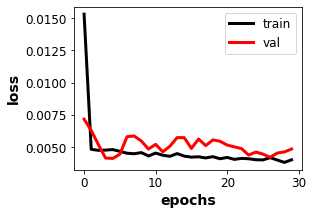

In [ ]:
# model name
model_name="CNN-4-seq"
#parameter grid
n_units=256
n_filters=256
kernel_size=6
n_epochs=30
n_steps_in=60
n_steps_out=1
n_features = X_train.shape[1]
#clear backend 
tf.keras.backend.clear_session()
# define model
inputs=Input((None,n_features))
x=Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu')(inputs)
x=Dense(n_units,activation="relu")(x)
x=Dense(n_steps_out, activation='linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain,
                  epochs=n_epochs,verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)
# save results to df
results_list.append([model_name,results])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","val loss"]
results_df.head(results_df.shape[0])    

# **Final Model and Predictions on TEST SET**

The best model was "LSTM 1-layer".

val loss = 0.00012056151172146201

 Time taken: 0 hours 1 minutes and 23.9 seconds.


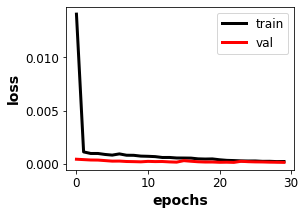

In [ ]:
#parameter grid
n_units=256
n_steps_in=60
n_steps_out=1 
n_epochs=30
n_features = X_train.shape[1]
#clear backend and set seeds 
tf.keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)
# define model
inputs=Input(((n_steps_in,n_features)))
x=LSTM(n_units)(inputs)  
x=Dense(n_steps_out,'linear')(x)
model=Model(inputs=inputs,outputs=x)
model.compile(optimizer='adam', loss='mse')
#_______________________________________________________________________________
# chronometer on
start_time = timer(None)
# generate LSTM sequences
Xtrain,ytrain=split_sequence(data_training,n_steps_in,n_steps_out)
Xtest,ytest=split_sequence(data_testing,n_steps_in,n_steps_out)
# model fit
history=model.fit(Xtrain, ytrain, epochs=n_epochs, verbose=0,validation_split=0.1,shuffle=True)
history_list.append(history)
# plot learning curves
plot_training(history)
# evaluate model
results=history.history["val_loss"][-1]
# print val loss
print(f"val loss = {results}")
# chronometer off
timer(start_time)

SMAPE: 50.0381427734375


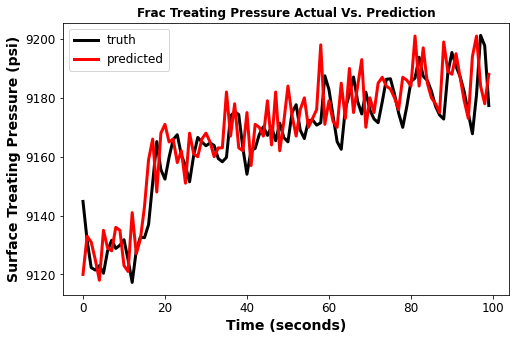

In [ ]:
# make predictions
prediction=model.predict(Xtest)
# invert back to PSI
y_pred,truth=invert(prediction,ytest.reshape(len(prediction),1),data)
# plot results
plot_results(y_pred,truth)
# print SMAPE
print(f"SMAPE: {smape_np(np.array(truth), np.array(y_pred))}")

#Summary of results and conclusions

The objective of this work was to perform the pressure prediction used in the hydraulic fracturing process from the injection flow of the billing fluid (slurry rate), using the Frac_Stage_Data dataset available. As the main prediction model a Long-Short Term Memory (LSTM) type network was used.

For the development of the prediction model, several architectures with different parameters were tested, seeking to infer
optimization of the parameters involved.

To perform the prediction, the methodology employed uses windows consisting of the last 60 seconds of fracturing fluid injection flow rate (slurry rate) and proppant concentration data to predict the injection pressure in the next second.

In general, it was noted that simpler models provided the best results. This fact is corroborated by the context of the problem, in fact, not being complex.
In this sense, three-tier LSTM models showed lower performance than one-tier models. As a result, subsequent tests were performed with models with only one layer.

Regarding the size of the learning windows, a better performance was noticed for LB=10 and 60. The performance was worse for models with windows greater than 60, indicating that the dependence on time is less than 60.

The use of dropout as a way to deactivate neurons to reduce overfitting did not lead to a significant improvement. This can be associated with the fact that one-layer LSTM model is not complex enough to notice improvement with the use of dropout.

The use of dense layer on top and a larger number of neurons did not improve the model either. The LSTM + Attention model also led to a significant drop in performance. On the other hand, the use of GRU, which consists of a simplified LSTM model, achieved a slightly superior performance than single-layer LSTM.

Other unconventional models for this context were also tested, including CNN (with sequential prediction), SVR, RandomForest and the Dense+CNN+LSTM combination led to results that did not perform consistently better than those obtained by LSTM with a single layer.

In addition to the fact that, in this case, simpler models present consistently better performances, the application of this prediction in real time also favors the use of models with lower computational cost.
Therefore, the model considered as the best, evaluating both the performance and computational cost issues was the LSTM 1-layer. Such model tested in the test set obtained val_loss=0.0001205 and SMAPE=50.0381

Such results are consistent with scientific articles in the area (BEN et al., 2020; PETTY & XU, 2011). Future work may involve the inclusion of additional variables. Furthermore, further study of prediction architectures can be carried out, mainly considering their deployment in the context of real-time operations.

---

References:

BEN, Yuxing et al. Real-time hydraulic fracturing pressure prediction with machine learning. In: SPE Hydraulic Fracturing Technology Conference and Exhibition. OnePetro, 2020.

PETTY, Nicholas A., and XU, Guanshui . "The Effects of Proppant Concentration on the Rheology of Slurries for Hydraulic Fracturing–A Review." Undergraduate Research Journal 45 (2011).